# Polynomial regression on multiple variables

Demonstration of polynomial regression on a multivariable dataset.

In [1]:
from sklearn import datasets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import median_absolute_error, r2_score

## Load data

Dataset citation: Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.

In [2]:
# Boston house price dataset
# http://scikit-learn.org/stable/datasets/index.html#boston-house-prices-dataset
houses = datasets.load_boston()

In [3]:
houses.data.shape

(506, 13)

In [4]:
houses.feature_names

array(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
       'TAX', 'PTRATIO', 'B', 'LSTAT'], dtype='<U7')

There are 506 examples, each with 13 features:
```
CRIM per capita crime rate by town
ZN proportion of residential land zoned for lots over 25,000 sq.ft.
INDUS proportion of non-retail business acres per town
CHAS Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
NOX nitric oxides concentration (parts per 10 million)
RM average number of rooms per dwelling
AGE proportion of owner-occupied units built prior to 1940
DIS weighted distances to five Boston employment centres
RAD index of accessibility to radial highways
TAX full-value property-tax rate per $10,000
PTRATIO pupil-teacher ratio by town
B 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
LSTAT % lower status of the population
```

`houses.target` contains the target data (house prices in $10,000).

## Inspect and clean data

### Put everything in a dataframe

In [5]:
data = pd.DataFrame(data=houses.data,
                   columns=houses.feature_names)

data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [6]:
prices = pd.DataFrame(data=houses.target,
                     columns=['PRICE'])

prices.head()

,PRICE
0,24.0
1,21.6
2,34.7
3,33.4
4,36.2


In [7]:
data = pd.concat([data, prices], axis=1)
data

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48,22.0


### Remove bad data

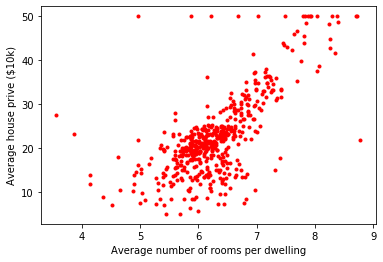

In [8]:
plt.plot(data['RM'], data['PRICE'], 'r.')
plt.xlabel('Average number of rooms per dwelling')
plt.ylabel('Average house prive ($10k)')
plt.show()

The examples with price $500,000 appear to be anomalies, either bad data or some kind of artificial ceiling. Let's remove them from the dataset.

In [9]:
data = data[data['PRICE']!=50]
len(data)

490

We only lost 16 examples.

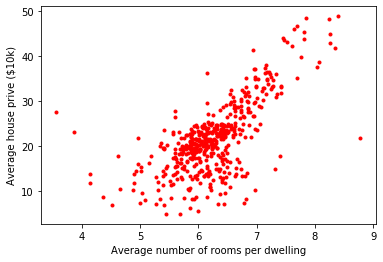

In [10]:
plt.plot(data['RM'], data['PRICE'], 'r.')
plt.xlabel('Average number of rooms per dwelling')
plt.ylabel('Average house prive ($10k)')
plt.show()

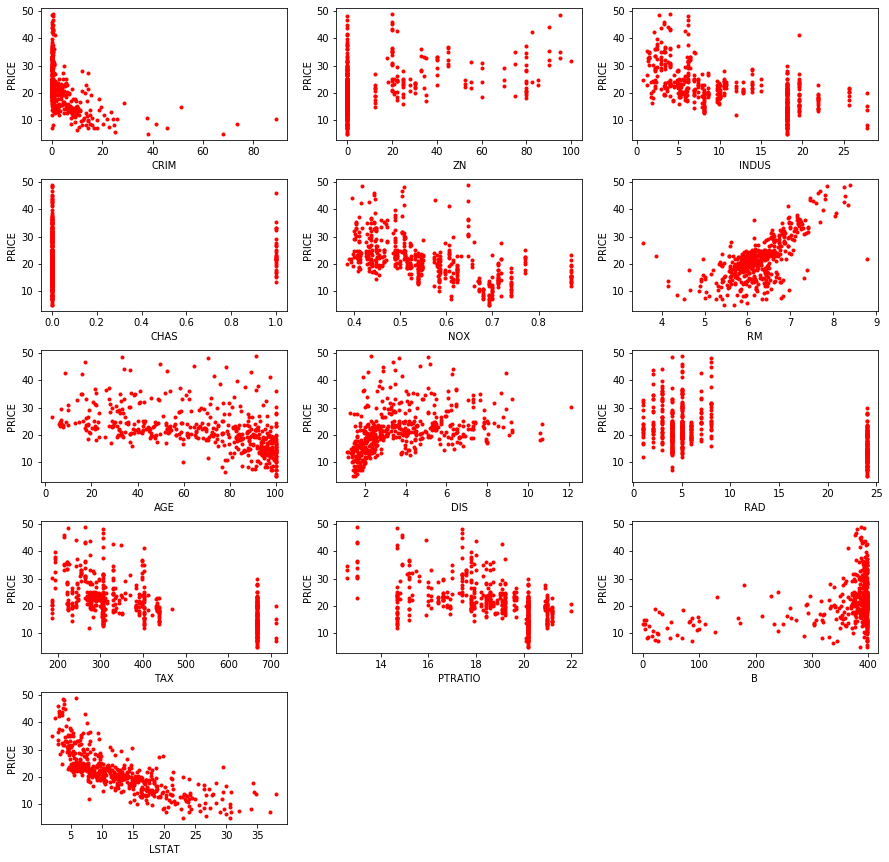

In [11]:
# Plot all variables against PRICE
n_features = len(data.columns) - 1 # -1 to exclude PRICE column
display_cols = 3
display_rows = math.ceil(n_features / display_cols)
plt.figure(figsize=(15, display_rows*3))

for i in range(n_features):
    plt.subplot(display_rows, display_cols, i+1)
    plt.plot(data.iloc[:, i], data['PRICE'], 'r.')
    plt.xlabel(data.columns[i])
    plt.ylabel('PRICE')
plt.subplots_adjust(hspace=0.3)
plt.show()

We see that CHAS does not correlate with price. We will remove this feature.

In [12]:
# Remove CHAS feature
data = data.drop('CHAS', axis=1)
data.head()

,CRIM,ZN,INDUS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


### Feature scaling

We'll use standardisation, i.e. for each feature we subtract the mean and divide by the standard deviation, so that each feature will have mean 0 and variance 1.

In [13]:
# Separate data from targets
n_features = len(data.columns) - 1 # -1 to exclude PRICE column

x = data.iloc[:, 0:n_features] # Everything except PRICE
y = data.iloc[:, -1] # PRICE

In [14]:
x = (x - x.mean()) / x.std()
# Should be standardised
x.head()

,CRIM,ZN,INDUS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,-0.416975,0.301504,-1.290537,-0.139752,0.504524,-0.109320,0.121084,-0.979633,-0.666420,-1.525721,0.443082,-1.121533
1,-0.414569,-0.486427,-0.592723,-0.731074,0.268743,0.377103,0.536782,-0.864576,-0.987724,-0.341155,0.443082,-0.534226
2,-0.414571,-0.486427,-0.592723,-0.731074,1.438464,-0.254892,0.536782,-0.864576,-0.987724,-0.341155,0.399145,-1.255654
3,-0.413989,-0.486427,-1.309595,-0.825342,1.152158,-0.798123,1.055799,-0.749518,-1.106726,0.085289,0.418577,-1.409539
4,-0.409783,-0.486427,-1.309595,-0.825342,1.380284,-0.499879,1.055799,-0.749518,-1.106726,0.085289,0.443082,-1.072120


In [15]:
# Should be unchanged
y.head()

0    24.0
1    21.6
2    34.7
3    33.4
4    36.2
Name: PRICE, dtype: float64

## Split into train and test data

In [16]:
# Put the data in a format we can use
x = x.to_numpy()
y = y.to_numpy()

# LinearReression() requires 2D input
y = y[:, np.newaxis]

In [17]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

## Train and test

In [18]:
# Define model
model = make_pipeline(PolynomialFeatures(degree=2, include_bias=False),
                     LinearRegression())

# Any higher than degree=2 leads to wild overfitting.

# PolynomialFeatures(include_bias=False) because LinearRegression()
# defaults to LinearRegression(fit_intercept=True). In other words,
# we only want to add bias once.

# Train
model.fit(x_train, y_train)

Pipeline(memory=None,
         steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=2, include_bias=False,
                                    interaction_only=False, order='C')),
                ('linearregression',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

In [19]:
# Predict
y_pred = model.predict(x_test)

### Visualise performance

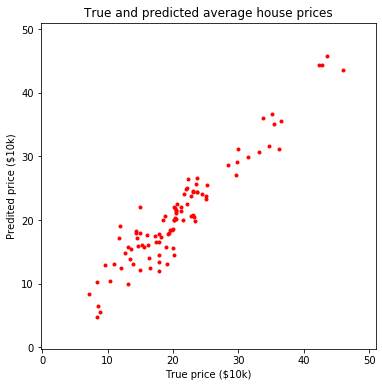

In [20]:
plt.figure(figsize=(6, 6))
plt.plot(y_test, y_pred, 'r.')
val_min = min(min(y_pred), min(y_test)) -5
val_max = max(max(y_pred), max(y_test)) + 5
plt.xlim(val_min, val_max)
plt.ylim(val_min, val_max)
plt.xlabel('True price ($10k)')
plt.ylabel('Predited price ($10k)')
plt.title('True and predicted average house prices')
plt.show()

A perfect prediction would give us a straight, 45-degree line.

### Quantify performance

In [21]:
print('Performance metrics:')
median_abs_err = (median_absolute_error(y_test, y_pred))*1e4
r2 = r2_score(y_test, y_pred)
print('  Median absolute error: $%.0f' %(median_abs_err))
print('  R2 score: %f' %(r2))

Performance metrics:
  Median absolute error: $16847
  R2 score: 0.897214


The performance metrics change every time the notebook is executed due to the randon train-test split and the small size of the dataset; R2 score varies between approximately 0.85-0.9. We could attain more consistent results if we had more data.

## Possible improvements

This is only a short demonstraction of polynomial regression. If we wanted to develop this further we could:

* Use more data (if available). This would give us better and more consistent results.
* Implement regularisation using a different sklearn [linear model](https://scikit-learn.org/stable/modules/linear_model.html). This might allow us to experiment with using higher order polynomials (at present, anything higher than `degree=2` leads to wild overfitting).
* Experiment with using only (non-)interacting features. This might reduce overiftting when using higher order polynomials.
* Hyperparameter tuning (e.g. order of polynomial, which features to include, regularisation parameter, etc.) using a grid search or similar technique, evaluated on a validation set.
* Depending on the final application of this analysis, we should consider if using all the variables is appropriate. E.g. `B 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town` might be appropriate for an academic study, but not for calculating insurance premiums.